In [26]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the data
forecast_sample = pd.read_csv('data/forecast_sample.csv')
forecast_sample.rename(columns={'EffectiveDate':'ds', 'Demand':'y'}, inplace=True)
df = forecast_sample.copy()

# Convert 'ds' column to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Sort the DataFrame by date
df = df.sort_values(by=['ds', 'ProductId', 'BranchId', 'Currency'])

# Add the day of the month column
df['DayOfMonth'] = df['ds'].dt.day

# Add the custom day numbering column
def custom_day_numbering(date):
    first_day_of_month = date.replace(day=1)
    day_of_week = date.dayofweek
    return (day_of_week + 1) + (date.day - 1) // 7 * 7

df['CustomDayNumber'] = df['ds'].apply(custom_day_numbering)

# Display the last few rows to verify the new columns
print(df.tail())

      BranchId CountryCode CountryName  ProductId Currency         ds  \
1485       244          ZM      Zambia        642      USD 2024-05-12   
2971       246          ZM      Zambia        643      USD 2024-05-12   
3714       246          ZM      Zambia        644      ZMW 2024-05-12   
5200       274          ZM      Zambia        895      ZMW 2024-05-12   
4457       274          ZM      Zambia        896      USD 2024-05-12   

            y  PlannedCashOutOrderCount  AvgPlannedCashOutOrderAmount  \
1485   1916.0                      27.0                      100.3333   
2971   4955.0                       6.0                      360.8333   
3714  59860.0                      41.0                      428.0488   
5200  31656.0                     272.0                      246.8015   
4457  11155.0                     252.0                      113.3929   

      ActualCashOutOrderAmount  AvgActualCashOutOrderAmount DayOfWeekName  \
1485                    2334.0               

In [27]:
df[['ds','CustomDayNumber']]

,ds,CustomDayNumber
0,2022-05-01,7
1486,2022-05-01,7
743,2022-05-01,7
2229,2022-05-01,7
2972,2022-05-01,7
...,...,...
1485,2024-05-12,14
2971,2024-05-12,14
3714,2024-05-12,14
5200,2024-05-12,14


In [28]:
# Display the last few rows of the DataFrame
print(df.tail())

# Store the original categorical columns
original_columns = ['ds', 'y', 'BranchId', 'ProductId', 'Currency']

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['BranchId', 'ProductId', 'Currency', 'DayOfWeekName', 'CustomDayNumber', 'DayOfMonth'], drop_first=True)

      BranchId CountryCode CountryName  ProductId Currency         ds  \
1485       244          ZM      Zambia        642      USD 2024-05-12   
2971       246          ZM      Zambia        643      USD 2024-05-12   
3714       246          ZM      Zambia        644      ZMW 2024-05-12   
5200       274          ZM      Zambia        895      ZMW 2024-05-12   
4457       274          ZM      Zambia        896      USD 2024-05-12   

            y  PlannedCashOutOrderCount  AvgPlannedCashOutOrderAmount  \
1485   1916.0                      27.0                      100.3333   
2971   4955.0                       6.0                      360.8333   
3714  59860.0                      41.0                      428.0488   
5200  31656.0                     272.0                      246.8015   
4457  11155.0                     252.0                      113.3929   

      ActualCashOutOrderAmount  AvgActualCashOutOrderAmount DayOfWeekName  \
1485                    2334.0               

In [29]:
list(df)

['CountryCode',
 'CountryName',
 'ds',
 'y',
 'PlannedCashOutOrderCount',
 'AvgPlannedCashOutOrderAmount',
 'ActualCashOutOrderAmount',
 'AvgActualCashOutOrderAmount',
 'BranchId_244',
 'BranchId_246',
 'BranchId_274',
 'ProductId_641',
 'ProductId_642',
 'ProductId_643',
 'ProductId_644',
 'ProductId_895',
 'ProductId_896',
 'Currency_ZMW',
 'DayOfWeekName_Monday',
 'DayOfWeekName_Saturday',
 'DayOfWeekName_Sunday',
 'DayOfWeekName_Thursday',
 'DayOfWeekName_Tuesday',
 'DayOfWeekName_Wednesday',
 'CustomDayNumber_2',
 'CustomDayNumber_3',
 'CustomDayNumber_4',
 'CustomDayNumber_5',
 'CustomDayNumber_6',
 'CustomDayNumber_7',
 'CustomDayNumber_8',
 'CustomDayNumber_9',
 'CustomDayNumber_10',
 'CustomDayNumber_11',
 'CustomDayNumber_12',
 'CustomDayNumber_13',
 'CustomDayNumber_14',
 'CustomDayNumber_15',
 'CustomDayNumber_16',
 'CustomDayNumber_17',
 'CustomDayNumber_18',
 'CustomDayNumber_19',
 'CustomDayNumber_20',
 'CustomDayNumber_21',
 'CustomDayNumber_22',
 'CustomDayNumber_23',


In [30]:
regressors = ['PlannedCashOutOrderCount',
 'AvgPlannedCashOutOrderAmount',
 'ActualCashOutOrderAmount',
 'AvgActualCashOutOrderAmount',
 'BranchId_244',
 'BranchId_246',
 'BranchId_274',
 'ProductId_641',
 'ProductId_642',
 'ProductId_643',
 'ProductId_644',
 'ProductId_895',
 'ProductId_896',
 'Currency_ZMW',
 'DayOfWeekName_Monday',
 'DayOfWeekName_Saturday',
 'DayOfWeekName_Sunday',
 'DayOfWeekName_Thursday',
 'DayOfWeekName_Tuesday',
 'DayOfWeekName_Wednesday',
 'CustomDayNumber_2',
 'CustomDayNumber_3',
 'CustomDayNumber_4',
 'CustomDayNumber_5',
 'CustomDayNumber_6',
 'CustomDayNumber_7',
 'CustomDayNumber_8',
 'CustomDayNumber_9',
 'CustomDayNumber_10',
 'CustomDayNumber_11',
 'CustomDayNumber_12',
 'CustomDayNumber_13',
 'CustomDayNumber_14',
 'CustomDayNumber_15',
 'CustomDayNumber_16',
 'CustomDayNumber_17',
 'CustomDayNumber_18',
 'CustomDayNumber_19',
 'CustomDayNumber_20',
 'CustomDayNumber_21',
 'CustomDayNumber_22',
 'CustomDayNumber_23',
 'CustomDayNumber_24',
 'CustomDayNumber_25',
 'CustomDayNumber_26',
 'CustomDayNumber_27',
 'CustomDayNumber_28',
 'CustomDayNumber_29',
 'CustomDayNumber_30',
 'CustomDayNumber_31',
 'CustomDayNumber_32',
 'CustomDayNumber_33',
 'CustomDayNumber_34',
 'CustomDayNumber_35',
 'DayOfMonth_2',
 'DayOfMonth_3',
 'DayOfMonth_4',
 'DayOfMonth_5',
 'DayOfMonth_6',
 'DayOfMonth_7',
 'DayOfMonth_8',
 'DayOfMonth_9',
 'DayOfMonth_10',
 'DayOfMonth_11',
 'DayOfMonth_12',
 'DayOfMonth_13',
 'DayOfMonth_14',
 'DayOfMonth_15',
 'DayOfMonth_16',
 'DayOfMonth_17',
 'DayOfMonth_18',
 'DayOfMonth_19',
 'DayOfMonth_20',
 'DayOfMonth_21',
 'DayOfMonth_22',
 'DayOfMonth_23',
 'DayOfMonth_24',
 'DayOfMonth_25',
 'DayOfMonth_26',
 'DayOfMonth_27',
 'DayOfMonth_28',
 'DayOfMonth_29',
 'DayOfMonth_30',
 'DayOfMonth_31']

# Define the split point
split_date = '2024-01-01'  # Change this to your desired split date
train = df[df['ds'] <= split_date]
test = df[df['ds'] > split_date]

# Initialize the Prophet model
model = Prophet()

for col in regressors:
    model.add_regressor(col)

# Fit the model on the training set
model.fit(train)

# Make predictions
forecast = model.predict(test)

16:04:59 - cmdstanpy - INFO - Chain [1] start processing
16:05:00 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
test

,CountryCode,CountryName,ds,y,PlannedCashOutOrderCount,AvgPlannedCashOutOrderAmount,ActualCashOutOrderAmount,AvgActualCashOutOrderAmount,BranchId_244,BranchId_246,...,DayOfMonth_22,DayOfMonth_23,DayOfMonth_24,DayOfMonth_25,DayOfMonth_26,DayOfMonth_27,DayOfMonth_28,DayOfMonth_29,DayOfMonth_30,DayOfMonth_31
611,ZM,Zambia,2024-01-02,121513.84,156.0,1609.6648,132413.84,1182.2664,False,False,...,False,False,False,False,False,False,False,False,False,False
2097,ZM,Zambia,2024-01-02,8752.00,24.0,295.8333,8752.00,397.8181,True,False,...,False,False,False,False,False,False,False,False,False,False
1354,ZM,Zambia,2024-01-02,1280.00,18.0,216.1111,1280.00,182.8571,True,False,...,False,False,False,False,False,False,False,False,False,False
2840,ZM,Zambia,2024-01-02,6425.00,210.0,70.2143,6425.00,66.9270,False,True,...,False,False,False,False,False,False,False,False,False,False
3583,ZM,Zambia,2024-01-02,48815.00,142.0,508.4859,47375.00,707.0895,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,ZM,Zambia,2024-05-12,1916.00,27.0,100.3333,2334.00,212.1818,True,False,...,False,False,False,False,False,False,False,False,False,False
2971,ZM,Zambia,2024-05-12,4955.00,6.0,360.8333,4955.00,381.1538,False,True,...,False,False,False,False,False,False,False,False,False,False
3714,ZM,Zambia,2024-05-12,59860.00,41.0,428.0488,56420.00,989.8245,False,True,...,False,False,False,False,False,False,False,False,False,False
5200,ZM,Zambia,2024-05-12,31656.00,272.0,246.8015,36056.00,308.1709,False,False,...,False,False,False,False,False,False,False,False,False,False


In [32]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,ActualCashOutOrderAmount,ActualCashOutOrderAmount_lower,ActualCashOutOrderAmount_upper,AvgActualCashOutOrderAmount,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-01-02,37163.821638,124730.927133,141242.193290,37163.821638,37163.821638,95923.959158,95923.959158,95923.959158,-209.016038,...,96267.296768,96267.296768,96267.296768,-76.825977,-76.825977,-76.825977,0.0,0.0,0.0,133354.292429
1,2024-01-02,37163.821638,2231.568945,18699.048095,37163.821638,37163.821638,-27893.660586,-27893.660586,-27893.660586,236.920816,...,-26658.769128,-26658.769128,-26658.769128,-76.825977,-76.825977,-76.825977,0.0,0.0,0.0,10428.226533
2,2024-01-02,37163.821638,-7322.565122,9310.354804,37163.821638,37163.821638,-35375.073241,-35375.073241,-35375.073241,359.120115,...,-35774.456413,-35774.456413,-35774.456413,-76.825977,-76.825977,-76.825977,0.0,0.0,0.0,1312.539248
3,2024-01-02,37163.821638,-5731.018914,10604.084013,37163.821638,37163.821638,-30223.591963,-30223.591963,-30223.591963,425.023124,...,-35179.012479,-35179.012479,-35179.012479,-76.825977,-76.825977,-76.825977,0.0,0.0,0.0,1907.983182
4,2024-01-02,37163.821638,38431.571919,54832.492098,37163.821638,37163.821638,10777.993720,10777.993720,10777.993720,61.108700,...,9303.177717,9303.177717,9303.177717,-76.825977,-76.825977,-76.825977,0.0,0.0,0.0,46390.173378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,2024-05-12,37460.595090,20764.046467,38069.911680,37124.972133,37814.733118,-8721.539398,-8721.539398,-8721.539398,-858.628035,...,-8411.189171,-8411.189171,-8411.189171,290.450840,290.450840,290.450840,0.0,0.0,0.0,29339.856759
920,2024-05-12,37460.595090,-5197.602681,11563.392614,37125.027223,37815.482432,-34319.745492,-34319.745492,-34319.745492,342.449845,...,-34446.007395,-34446.007395,-34446.007395,290.450840,290.450840,290.450840,0.0,0.0,0.0,3305.038535
921,2024-05-12,37460.595090,-7148.706549,9486.223517,37125.082312,37816.231746,-31695.443757,-31695.443757,-31695.443757,246.394003,...,-35966.937450,-35966.937450,-35966.937450,290.450840,290.450840,290.450840,0.0,0.0,0.0,1784.108480
922,2024-05-12,37460.595090,47999.501028,65123.355326,37124.594633,37816.981060,19834.387921,19834.387921,19834.387921,-99.618216,...,18811.593751,18811.593751,18811.593751,290.450840,290.450840,290.450840,0.0,0.0,0.0,56562.639681


In [33]:
# Calculate evaluation metrics
y_true = test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')


Mean Absolute Error: 38418.17308615982
Mean Squared Error: 5085657884.333746


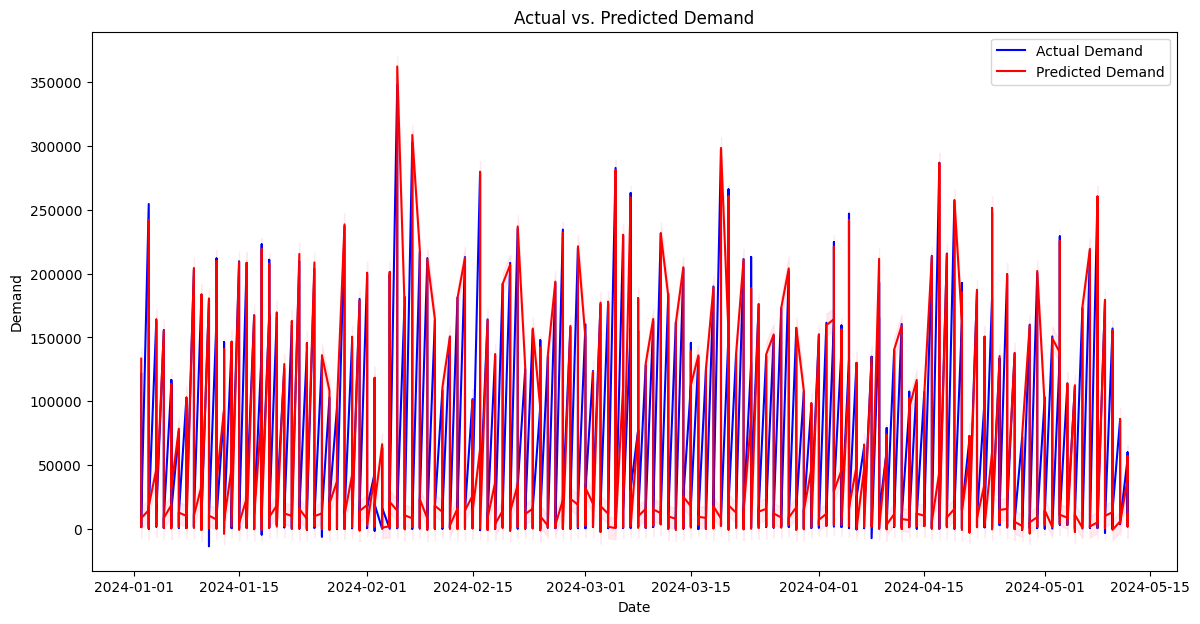

In [34]:
# Plot actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_true, label='Actual Demand', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted Demand', color='red')
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs. Predicted Demand')
plt.legend()
plt.show()

Predictions for the next 7 days with safety levels:
            ds          yhat    yhat_lower    yhat_upper   yhat_safety
917 2024-05-12  39059.633161  30666.417633  47686.451165  42965.596477
918 2024-05-12  56907.934204  48649.947361  65521.526541  62598.727625
919 2024-05-12  29339.856759  20764.046467  38069.911680  32273.842435
920 2024-05-12   3305.038535  -5197.602681  11563.392614   3635.542389
921 2024-05-12   1784.108480  -7148.706549   9486.223517   1962.519328
922 2024-05-12  56562.639681  47999.501028  65123.355326  62218.903650
923 2024-05-12  11686.758023   3392.384490  19614.210973  12855.433825


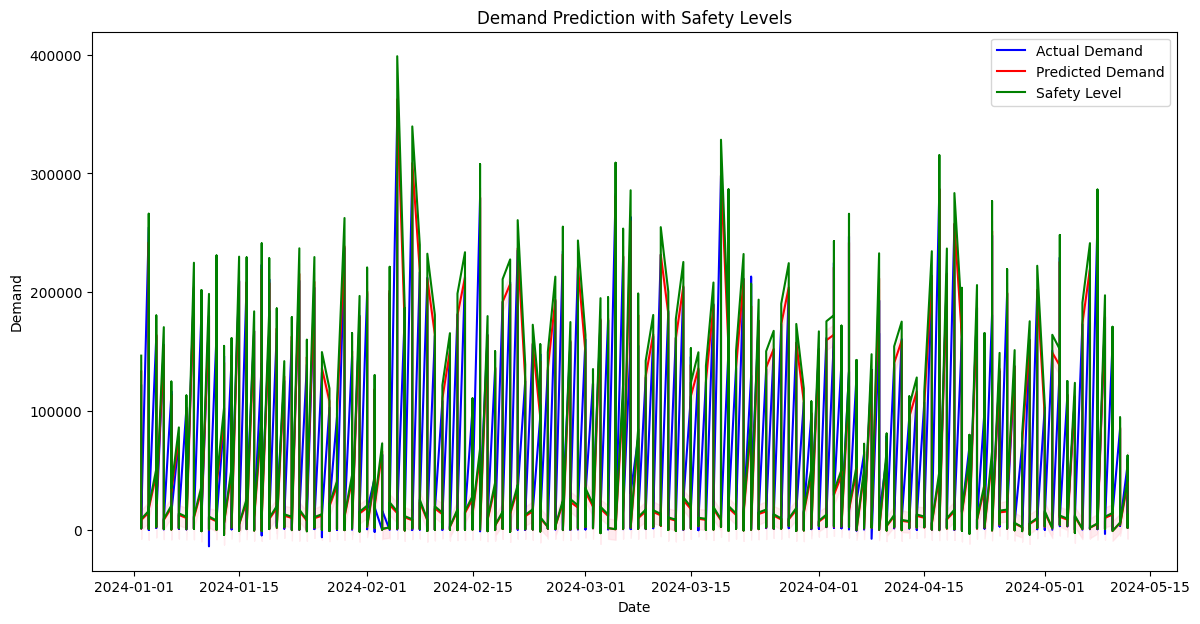

In [35]:
# Define a safety buffer (e.g., 10% of the predicted value)
safety_buffer_percentage = 0.10
forecast['yhat_safety'] = forecast['yhat'] * (1 + safety_buffer_percentage)

# Ensure that each branch would have sufficient supply seven days in advance
forecast_7_days = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_safety']].tail(7)

print("Predictions for the next 7 days with safety levels:")
print(forecast_7_days)

# Visualize the safety levels
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_true, label='Actual Demand', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted Demand', color='red')
plt.plot(test['ds'], forecast['yhat_safety'], label='Safety Level', color='green')
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Demand Prediction with Safety Levels')
plt.legend()
plt.show()


In [16]:
len(y_true)

924

In [15]:
forecast.shape

(924, 77)

In [17]:
forecast['y_true']=y_true

In [18]:
forecast_7_days = forecast[['ds', 'y_true','yhat', 'yhat_lower', 'yhat_upper', 'yhat_safety']].tail(7)

print("Predictions for the next 7 days with safety levels:")
print(forecast_7_days)

Predictions for the next 7 days with safety levels:
            ds   y_true          yhat    yhat_lower    yhat_upper  \
917 2024-05-12  54800.0  38655.817376  29678.825427  47255.908095   
918 2024-05-12  27900.0  56579.201215  48310.480209  65458.985071   
919 2024-05-12   1916.0  29031.152907  20368.299696  37467.147950   
920 2024-05-12   4955.0   2946.902895  -6334.042333  11039.463432   
921 2024-05-12  59860.0   1439.491199  -7085.673909  10920.744739   
922 2024-05-12  31656.0  56189.484844  47590.588820  65384.903924   
923 2024-05-12  11155.0  11310.999246   2959.733526  20583.820929   

      yhat_safety  
917  42521.399113  
918  62237.121337  
919  31934.268197  
920   3241.593185  
921   1583.440318  
922  61808.433328  
923  12442.099171  


/Users/christostrydom/github_repos/korridor_cf/venv/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/christostrydom/github_repos/korridor_cf/venv/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


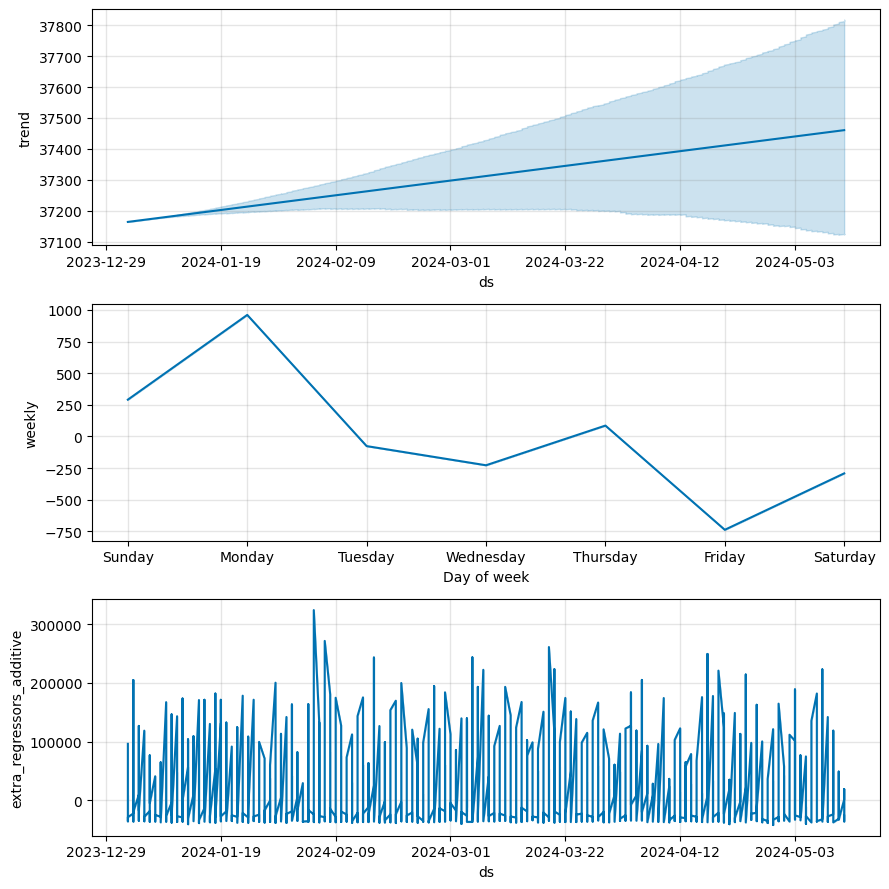

In [36]:
fig = model.plot_components(forecast)
plt.show()


In [49]:
import pandas as pd

# Load the data
forecast_sample = pd.read_csv('data/forecast_sample.csv')
forecast_sample.rename(columns={'EffectiveDate': 'ds', 'Demand': 'y'}, inplace=True)

# Convert 'ds' column to datetime
forecast_sample['ds'] = pd.to_datetime(forecast_sample['ds'])

# Sort the DataFrame by date
forecast_sample = forecast_sample.sort_values(by=['ds', 'ProductId', 'BranchId', 'Currency'])

# Display the first few rows of the DataFrame
print(forecast_sample.head())


      BranchId CountryCode CountryName  ProductId Currency         ds  \
0           21          ZM      Zambia         72      ZMW 2022-05-01   
1486       244          ZM      Zambia        641      ZMW 2022-05-01   
743        244          ZM      Zambia        642      USD 2022-05-01   
2229       246          ZM      Zambia        643      USD 2022-05-01   
2972       246          ZM      Zambia        644      ZMW 2022-05-01   

            y  PlannedCashOutOrderCount  AvgPlannedCashOutOrderAmount  \
0     38590.0                     115.0                      472.2609   
1486  14360.0                      15.0                      574.6667   
743    1970.0                      10.0                      355.5000   
2229   -200.0                       4.0                       50.0000   
2972  12100.0                      34.0                      592.3529   

      ActualCashOutOrderAmount  AvgActualCashOutOrderAmount DayOfWeekName  
0                      38590.0                

In [51]:
forecast_sample

,BranchId,CountryCode,CountryName,ProductId,Currency,y,PlannedCashOutOrderCount,AvgPlannedCashOutOrderAmount,ActualCashOutOrderAmount,AvgActualCashOutOrderAmount,DayOfWeekName
ds,,,,,,,,,,,
2022-05-01,21,ZM,Zambia,72,ZMW,38590.0,115.0,472.2609,38590.0,665.3448,Sunday
2022-05-01,244,ZM,Zambia,641,ZMW,14360.0,15.0,574.6667,10480.0,551.5789,Sunday
2022-05-01,244,ZM,Zambia,642,USD,1970.0,10.0,355.5000,1970.0,179.0909,Sunday
2022-05-01,246,ZM,Zambia,643,USD,-200.0,4.0,50.0000,100.0,50.0000,Sunday
2022-05-01,246,ZM,Zambia,644,ZMW,12100.0,34.0,592.3529,12100.0,1728.5714,Sunday
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-12,244,ZM,Zambia,642,USD,1916.0,27.0,100.3333,2334.0,212.1818,Sunday
2024-05-12,246,ZM,Zambia,643,USD,4955.0,6.0,360.8333,4955.0,381.1538,Sunday
2024-05-12,246,ZM,Zambia,644,ZMW,59860.0,41.0,428.0488,56420.0,989.8245,Sunday


In [50]:
# Set the index to the date column
forecast_sample.set_index('ds', inplace=True)

# Select numeric columns for resampling
numeric_columns = forecast_sample.select_dtypes(include=['number']).columns

# Resample the numeric columns to weekly frequency and sum the demand
weekly_df_numeric = forecast_sample[numeric_columns].resample('W').sum()

# For non-numeric columns, you might want to keep the first entry or use a more complex logic
non_numeric_columns = forecast_sample.select_dtypes(exclude=['number']).columns

# For simplicity, let's take the first entry of the non-numeric columns for each week
weekly_df_non_numeric = forecast_sample[non_numeric_columns].resample('W').first()

# Combine the numeric and non-numeric resampled dataframes
weekly_df = pd.concat([weekly_df_numeric, weekly_df_non_numeric], axis=1).reset_index()

# Display the first few rows of the resampled DataFrame
print(weekly_df.head())


          ds  BranchId  ProductId           y  PlannedCashOutOrderCount  \
0 2022-05-01      1549       4433    94171.00                     187.0   
1 2022-05-08     10843      31031  1282659.67                    1267.0   
2 2022-05-15     10843      31031  1309228.50                    1471.0   
3 2022-05-22     10843      31031  1464716.43                    1475.0   
4 2022-05-29     10843      31031  1514611.57                    1305.0   

   AvgPlannedCashOutOrderAmount  ActualCashOutOrderAmount  \
0                     4371.2091                  83160.00   
1                    59517.7146                1253684.51   
2                    52550.7059                1336462.26   
3                    57500.0577                1440052.60   
4                    58201.4291                1518728.96   

   AvgActualCashOutOrderAmount CountryCode CountryName Currency DayOfWeekName  
0                    5209.3360          ZM      Zambia      ZMW        Sunday  
1                   58

In [52]:
weekly_df

,ds,BranchId,ProductId,y,PlannedCashOutOrderCount,AvgPlannedCashOutOrderAmount,ActualCashOutOrderAmount,AvgActualCashOutOrderAmount,CountryCode,CountryName,Currency,DayOfWeekName
0,2022-05-01,1549,4433,94171.00,187.0,4371.2091,83160.00,5209.3360,ZM,Zambia,ZMW,Sunday
1,2022-05-08,10843,31031,1282659.67,1267.0,59517.7146,1253684.51,58897.7991,ZM,Zambia,ZMW,Monday
2,2022-05-15,10843,31031,1309228.50,1471.0,52550.7059,1336462.26,56579.0986,ZM,Zambia,ZMW,Monday
3,2022-05-22,10843,31031,1464716.43,1475.0,57500.0577,1440052.60,57417.3879,ZM,Zambia,ZMW,Monday
4,2022-05-29,10843,31031,1514611.57,1305.0,58201.4291,1518728.96,58956.2168,ZM,Zambia,ZMW,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...
102,2024-04-14,10843,31031,2341920.67,4002.0,36341.1010,2317070.73,37541.7906,ZM,Zambia,ZMW,Monday
103,2024-04-21,10843,31031,2707439.50,3768.0,37310.6051,2666527.50,34379.4082,ZM,Zambia,ZMW,Monday
104,2024-04-28,10843,31031,2695084.30,4462.0,31845.2748,2727736.92,32854.2115,ZM,Zambia,ZMW,Monday
105,2024-05-05,10843,31031,2329220.42,2915.0,38417.1380,2272426.93,37886.5122,ZM,Zambia,ZMW,Monday


In [44]:
list(forecast_sample)

['BranchId',
 'CountryCode',
 'CountryName',
 'ProductId',
 'Currency',
 'ds',
 'y',
 'PlannedCashOutOrderCount',
 'AvgPlannedCashOutOrderAmount',
 'ActualCashOutOrderAmount',
 'AvgActualCashOutOrderAmount',
 'DayOfWeekName']

In [55]:
weekly_df.drop(columns=['CountryCode','CountryName','Currency'])

,ds,BranchId,ProductId,y,PlannedCashOutOrderCount,AvgPlannedCashOutOrderAmount,ActualCashOutOrderAmount,AvgActualCashOutOrderAmount,DayOfWeekName
0,2022-05-01,1549,4433,94171.00,187.0,4371.2091,83160.00,5209.3360,Sunday
1,2022-05-08,10843,31031,1282659.67,1267.0,59517.7146,1253684.51,58897.7991,Monday
2,2022-05-15,10843,31031,1309228.50,1471.0,52550.7059,1336462.26,56579.0986,Monday
3,2022-05-22,10843,31031,1464716.43,1475.0,57500.0577,1440052.60,57417.3879,Monday
4,2022-05-29,10843,31031,1514611.57,1305.0,58201.4291,1518728.96,58956.2168,Monday
...,...,...,...,...,...,...,...,...,...
102,2024-04-14,10843,31031,2341920.67,4002.0,36341.1010,2317070.73,37541.7906,Monday
103,2024-04-21,10843,31031,2707439.50,3768.0,37310.6051,2666527.50,34379.4082,Monday
104,2024-04-28,10843,31031,2695084.30,4462.0,31845.2748,2727736.92,32854.2115,Monday
105,2024-05-05,10843,31031,2329220.42,2915.0,38417.1380,2272426.93,37886.5122,Monday


In [57]:
# Prepare the data for the Prophet model
df = weekly_df.drop(columns=['CountryCode','CountryName']).copy()

# Store the original categorical columns
original_columns = ['ds', 'y', 'BranchId', 'ProductId', 'Currency']

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['BranchId', 'ProductId', 'Currency', 'DayOfWeekName'], drop_first=True)

# Define the split point
split_date = '2024-01-01'  # Change this to your desired split date
train = df[df['ds'] <= split_date]
test = df[df['ds'] > split_date]

# Initialize the Prophet model
model = Prophet()

# Define the regressors including the new columns
regressors = [col for col in df.columns if col not in original_columns]

for col in regressors:
    model.add_regressor(col)

# Fit the model on the training set
model.fit(train)

18:31:59 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 38413.80627426224
Mean Squared Error: 1932485484.902592
           ds      y_true         y_hat
88 2024-01-07  2354340.99  2.269852e+06
89 2024-01-14  2499985.15  2.481874e+06
90 2024-01-21  2895498.68  2.933858e+06
91 2024-01-28  2525280.28  2.530649e+06
92 2024-02-04  2165162.29  2.082409e+06


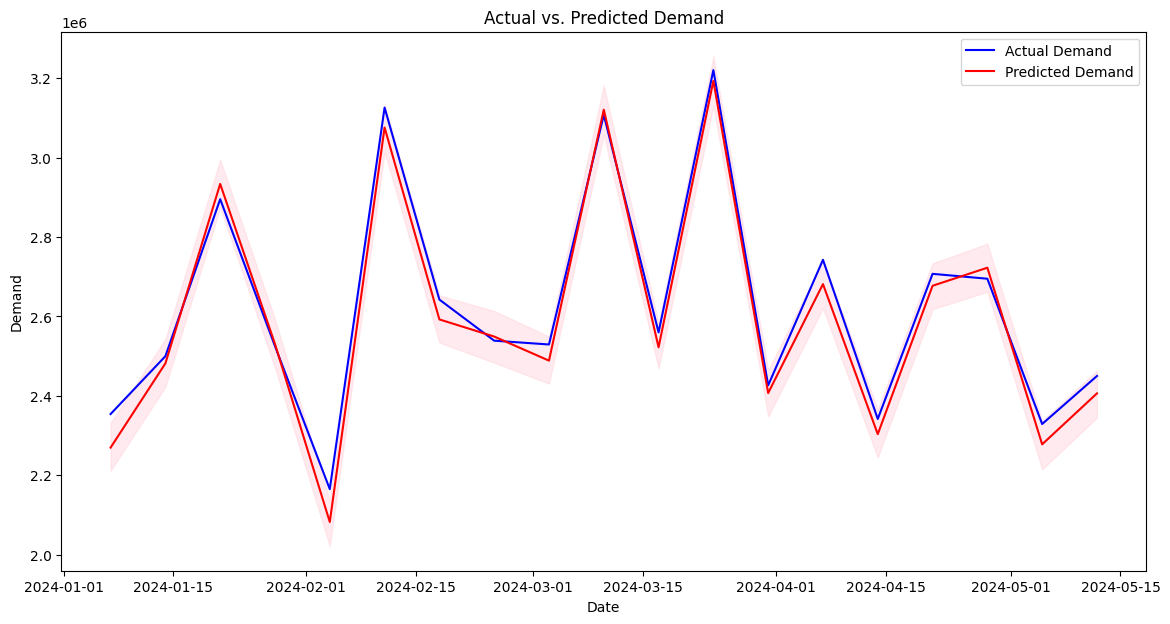

Predictions for the next 7 days with safety levels:
           ds          yhat    yhat_lower    yhat_upper   yhat_safety
12 2024-03-31  2.407210e+06  2.348212e+06  2.464420e+06  2.647931e+06
13 2024-04-07  2.681589e+06  2.621076e+06  2.741692e+06  2.949748e+06
14 2024-04-14  2.303719e+06  2.244948e+06  2.365615e+06  2.534091e+06
15 2024-04-21  2.677340e+06  2.618600e+06  2.733888e+06  2.945074e+06
16 2024-04-28  2.722843e+06  2.662228e+06  2.783168e+06  2.995127e+06
17 2024-05-05  2.278052e+06  2.215326e+06  2.336566e+06  2.505857e+06
18 2024-05-12  2.406306e+06  2.345259e+06  2.463744e+06  2.646936e+06


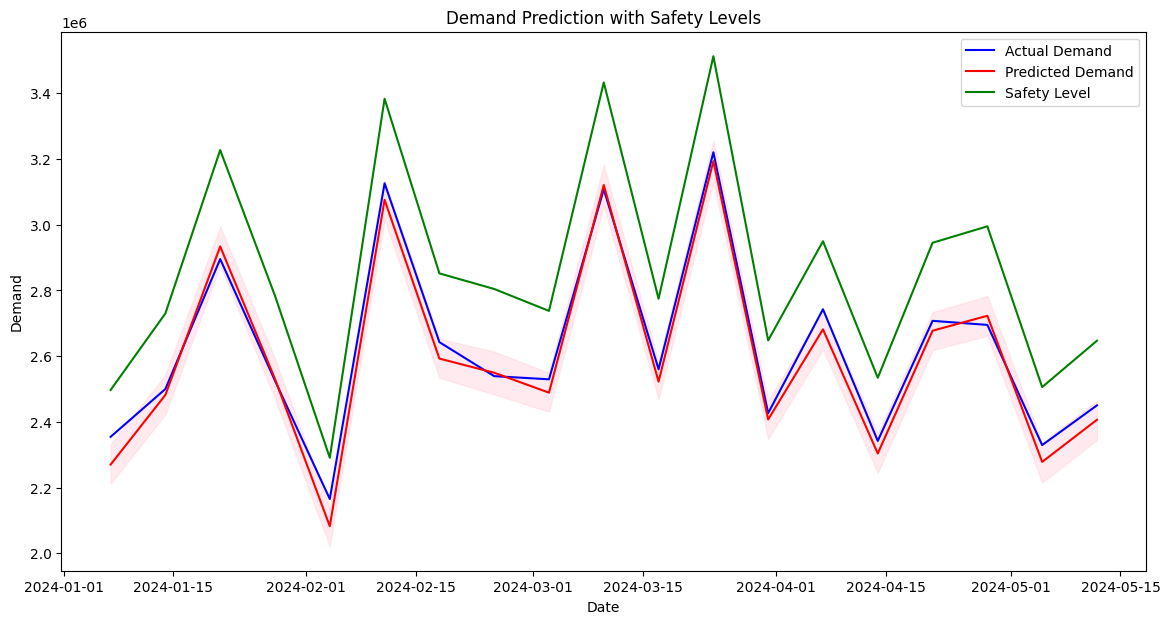

In [58]:
# Make predictions
forecast = model.predict(test)

# Calculate evaluation metrics
y_true = test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Combine y_true and y_hat into a single DataFrame
comparison_df = pd.DataFrame({'ds': test['ds'], 'y_true': y_true, 'y_hat': y_pred})

# Display the combined DataFrame
print(comparison_df.head())

# Visualize actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_true, label='Actual Demand', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted Demand', color='red')
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs. Predicted Demand')
plt.legend()
plt.show()

# Define a safety buffer (e.g., 10% of the predicted value)
safety_buffer_percentage = 0.10
forecast['yhat_safety'] = forecast['yhat'] * (1 + safety_buffer_percentage)

# Ensure that each branch would have sufficient supply seven days in advance
forecast_7_days = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_safety']].tail(7)

print("Predictions for the next 7 days with safety levels:")
print(forecast_7_days)

# Visualize the safety levels
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_true, label='Actual Demand', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted Demand', color='red')
plt.plot(test['ds'], forecast['yhat_safety'], label='Safety Level', color='green')
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Demand Prediction with Safety Levels')
plt.legend()
plt.show()

In [ ]:
# Fit the model on the training set
model.fit(train)

# Make predictions
forecast = model.predict(test)

# Calculate evaluation metrics
y_true = test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Combine y_true and y_hat into a single DataFrame
comparison_df = pd.DataFrame({'ds': test['ds'], 'y_true': y_true, 'y_hat': y_pred})

# Display the combined DataFrame
print(comparison_df.head())

# Visualize actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_true, label='Actual Demand', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted Demand', color='red')
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Actual vs. Predicted Demand')
plt.legend()
plt.show()

# Define a safety buffer (e.g., 10% of the predicted value)
safety_buffer_percentage = 0.10
forecast['yhat_safety'] = forecast['yhat'] * (1 + safety_buffer_percentage)

# Ensure that each branch would have sufficient supply seven days in advance
forecast_7_days = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'yhat_safety']].tail(7)

print("Predictions for the next 7 days with safety levels:")
print(forecast_7_days)

# Visualize the safety levels
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_true, label='Actual Demand', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted Demand', color='red')
plt.plot(test['ds'], forecast['yhat_safety'], label='Safety Level', color='green')
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Demand Prediction with Safety Levels')
plt.legend()
plt.show()

ValueError: Unable to parse string "ZMZMZMZMZMZMZM" at position 0